In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn import metrics

In [2]:
train_folder = '/kaggle/input/tr-sign-language/tr_signLanguage_dataset/train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/tr-sign-language/tr_signLanguage...
1,N,/kaggle/input/tr-sign-language/tr_signLanguage...
2,N,/kaggle/input/tr-sign-language/tr_signLanguage...
3,N,/kaggle/input/tr-sign-language/tr_signLanguage...
4,N,/kaggle/input/tr-sign-language/tr_signLanguage...
...,...,...
119395,J,/kaggle/input/tr-sign-language/tr_signLanguage...
119396,J,/kaggle/input/tr-sign-language/tr_signLanguage...
119397,J,/kaggle/input/tr-sign-language/tr_signLanguage...
119398,J,/kaggle/input/tr-sign-language/tr_signLanguage...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 85968 validated image filenames belonging to 26 classes.
Found 21492 validated image filenames belonging to 26 classes.
Found 11940 validated image filenames belonging to 26 classes.


In [5]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (64, 64, 3))
base_model.trainable = False ## Not trainable weights

2022-06-18 15:39:50.020024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:50.129233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:50.130062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 15:39:50.131354: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
#dense_layer_2 = layers.Dense(512, activation='relu')
#dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(26, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    #dense_layer_2,
    #dropout_layer_2,
    prediction_layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                13338     
Total params: 15,777,114
Trainable params: 1,062,426
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
classes = 26
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-06-18 15:39:54.386893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-18 15:39:56.564198: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


672/672 [==============================] - 647s 952ms/step - loss: 1.8093 - accuracy: 0.4743 - val_loss: 1.0296 - val_accuracy: 0.7386
Epoch 2/10
672/672 [==============================] - 159s 237ms/step - loss: 1.0021 - accuracy: 0.7062 - val_loss: 0.7196 - val_accuracy: 0.8186
Epoch 3/10
672/672 [==============================] - 159s 237ms/step - loss: 0.7548 - accuracy: 0.7817 - val_loss: 0.5656 - val_accuracy: 0.8566
Epoch 4/10
672/672 [==============================] - 162s 241ms/step - loss: 0.6141 - accuracy: 0.8211 - val_loss: 0.4692 - val_accuracy: 0.8776
Epoch 5/10
672/672 [==============================] - 159s 237ms/step - loss: 0.5202 - accuracy: 0.8494 - val_loss: 0.4014 - val_accuracy: 0.8945
Epoch 6/10
672/672 [==============================] - 173s 257ms/step - loss: 0.4476 - accuracy: 0.8688 - val_loss: 0.3492 - val_accuracy: 0.9084
Epoch 7/10
672/672 [==============================] - 212s 315ms/step - loss: 0.3984 - accuracy: 0.8851 - val_loss: 0.3128 - val_accura

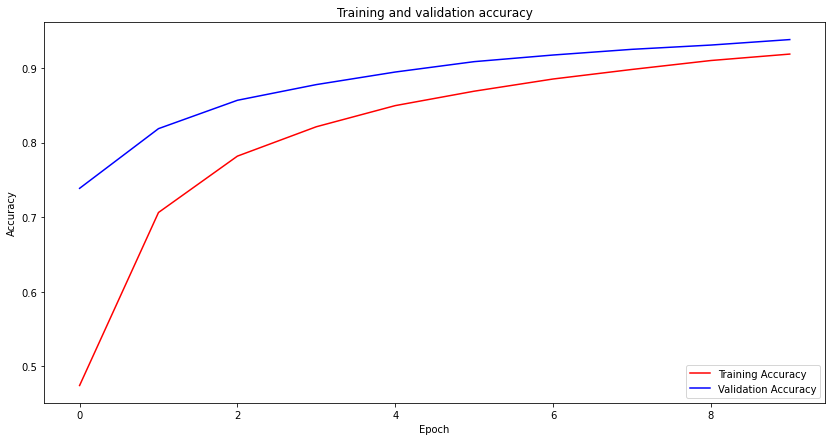

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

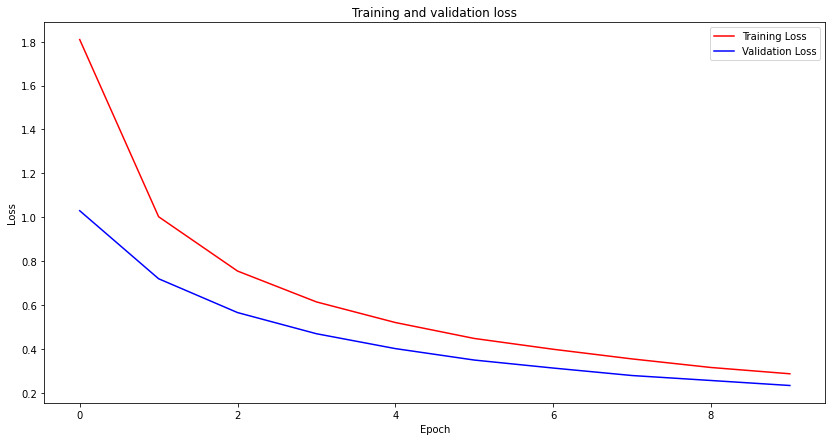

In [11]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

94/94 [==============================] - 98s 1s/step
              precision    recall  f1-score   support

           A       0.92      0.95      0.93       480
           B       0.97      0.98      0.98       480
           C       0.94      0.96      0.95       480
           D       0.93      0.90      0.92       480
           E       0.96      0.95      0.95       480
           F       0.96      0.94      0.95       480
           G       0.95      0.92      0.94       480
           H       0.95      0.95      0.95       480
           I       0.92      0.97      0.94       480
           J       0.94      0.88      0.91       480
           K       0.93      0.94      0.93       480
           L       0.89      0.93      0.91       480
           M       0.89      0.91      0.90       480
           N       0.88      0.89      0.88       480
           O       0.98      0.93      0.95       480
           P       0.98      0.96      0.97       480
           R       0.94     

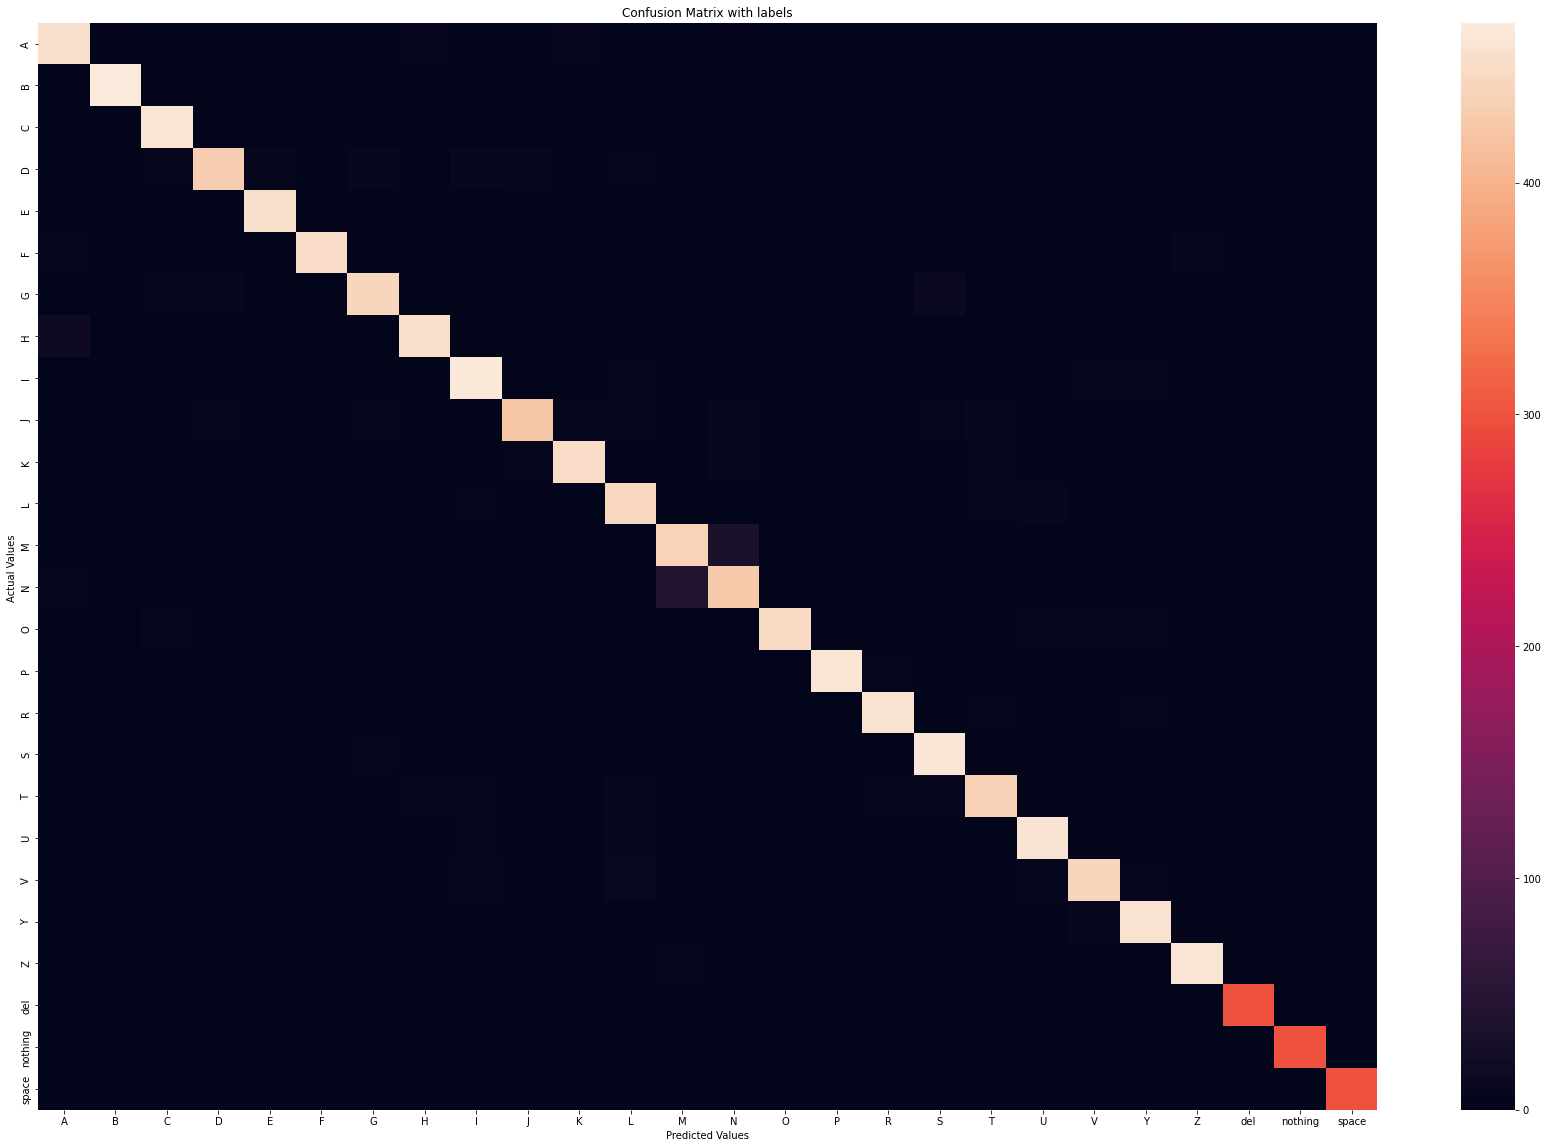

In [13]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [14]:
model.save('VGG16TrSL.h5')

In [15]:
from keras.models import model_from_json
json_model = model.to_json()

with open('VGG16TrSL.json', 'w') as json_file:
    json_file.write(json_model)

In [16]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[455   3   1   0   0   0   0   6   0   0   4   1   1   3   0   1   1   1
    0   1   0   0   2   0   0   0]
 [  0 469   0   1   0   1   0   1   1   0   1   0   2   0   1   1   1   0
    0   1   0   0   0   0   0   0]
 [  1   0 460   2   0   0   1   0   1   0   0   1   1   2   3   1   0   2
    0   2   1   0   2   0   0   0]
 [  0   0   5 431   6   0   8   0   9   6   2   4   0   0   1   0   3   2
    2   0   0   0   1   0   0   0]
 [  2   0   1   3 456   0   1   2   2   0   3   3   0   0   0   1   1   2
    2   1   0   0   0   0   0   0]
 [  6   0   2   0   0 450   1   2   2   2   1   0   0   3   0   0   1   1
    0   0   0   2   7   0   0   0]
 [  1   1   4   7   3   0 442   0   0   3   2   1   0   0   0   0   3  11
    2   0   0   0   0   0   0   0]
 [ 16   0   1   0   0   2   0 455   0   1   0   1   0   1   0   2   0   0
    0   0   0   0   1   0   0   0]
 [  1   0   0   0   0   0   0   0 464   0   0   4   0   0   0   1   0   0
    1   1   4   4   0   0   0   0]
 

<AxesSubplot:>

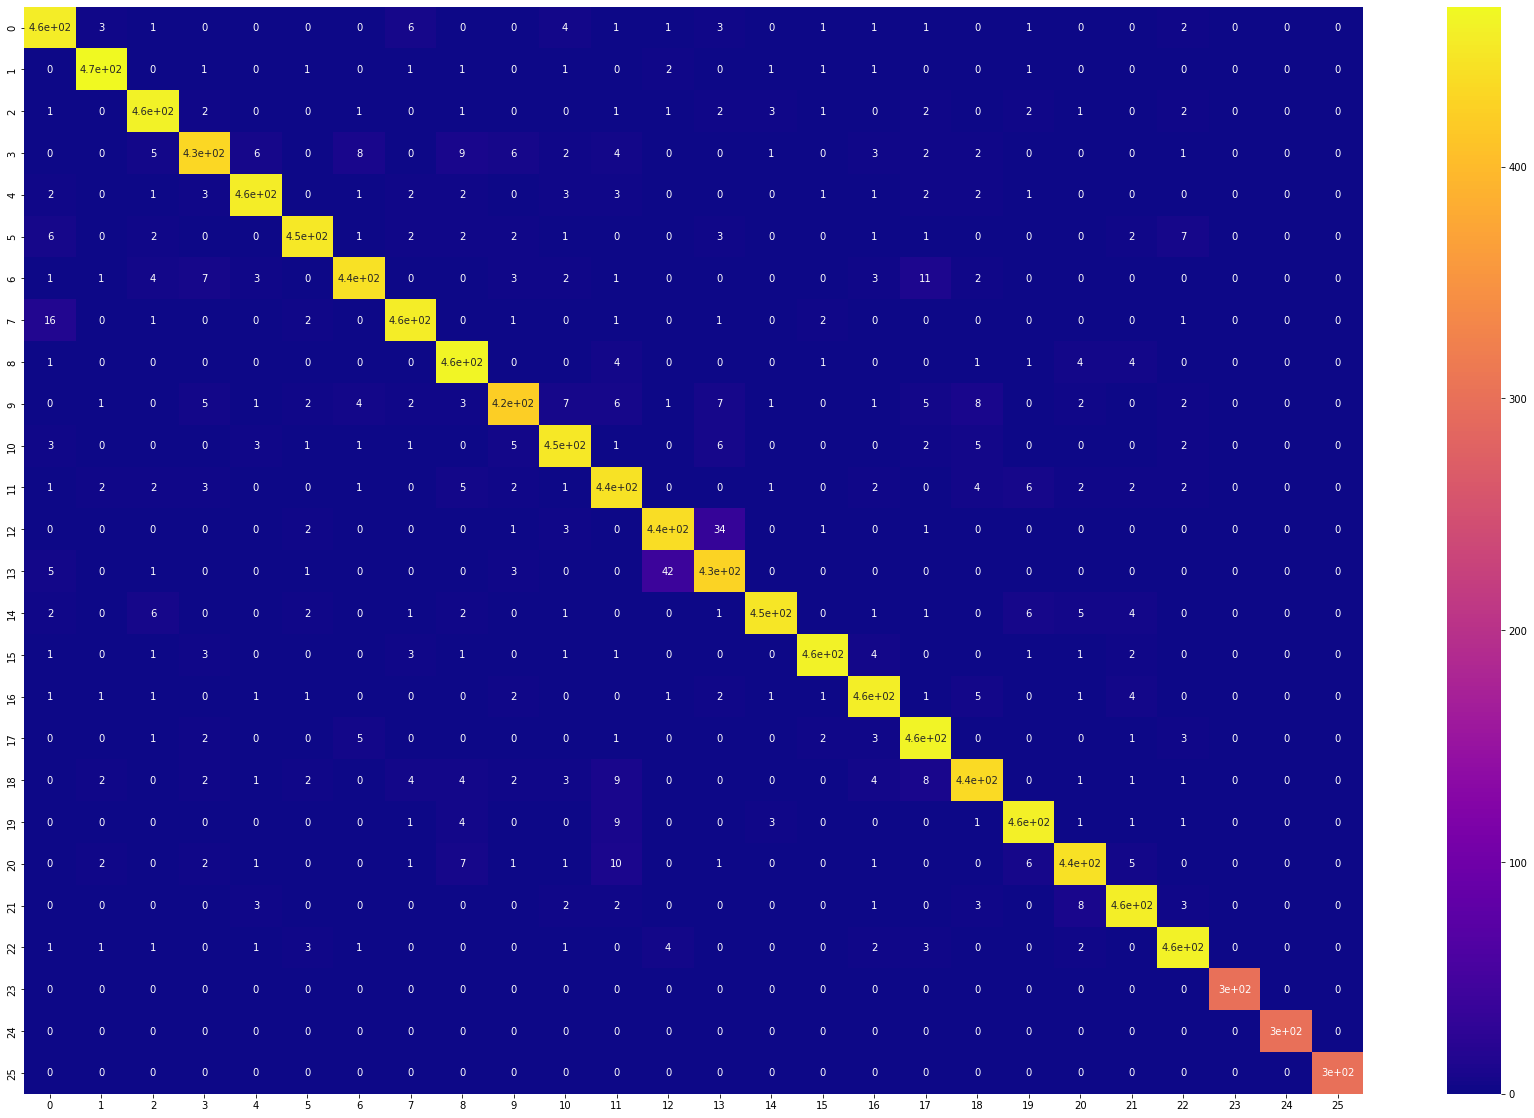

In [17]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)